In [9]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle

# Constants
IMG_SIZE = 256
BATCH_SIZE = 32

# Updated dataset paths:
# Previously images were separated by mode and bandwidth.
# Now all modes are together, grouped by bandwidth.
IMG_PATHS = {
    "High": "Multiplexer_combined_bandwidths/combined_high_bw",
    "Low": "Multiplexer_combined_bandwidths/combined_low_bw",
}

def load_images_by_bandwidth(img_paths):
    images, labels, names = [], [], []
    for bandwidth, path in img_paths.items():
        # Assign labels based on bandwidth
        label = 1 if bandwidth == "High" else 0
        count = 0  # count images loaded from this folder

        # List all files in the folder and load images
        for img_name in os.listdir(path):
            
            img_path = os.path.join(path, img_name)
            # Load the image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0  # Normalize
            images.append(img)
            labels.append(label)
            names.append(img_name)
            count += 1

        print(f"Imported {count} images from {path} (bandwidth: {bandwidth})")

    # Format data for training/testing
    images = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    labels = np.array(labels)
    names = np.array(names)
    return shuffle(images, labels, names, random_state=42)


# Import images using the updated scheme
images, labels, names = load_images_by_bandwidth(IMG_PATHS)

Imported 111 images from Multiplexer_combined_bandwidths/combined_high_bw (bandwidth: High)
Imported 110 images from Multiplexer_combined_bandwidths/combined_low_bw (bandwidth: Low)


In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


# CNN model definition
def build_cnn_model():
    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(2, activation="softmax"),  # Binary output for High vs Low
        ]
    )

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

2025-05-03 13:08:34.806796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746241715.297654    5415 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746241715.435812    5415 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746241716.568125    5415 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746241716.568148    5415 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746241716.568151    5415 computation_placer.cc:177] computation placer alr

In [3]:
# Train and save models for each mode
model_name = "cnn_v4_combined_model_v1"

model = build_cnn_model()
history = model.fit(x_train, y_train, epochs=20, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))
model.save(f"{model_name}.h5")

/home/maxwell/miniconda3/envs/lime/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744888652.160435 4031525 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3849 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/20


2025-04-17 21:17:33.087139: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 46137344 exceeds 10% of free system memory.
2025-04-17 21:17:33.120322: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 46137344 exceeds 10% of free system memory.
I0000 00:00:1744888654.524008 4031579 service.cc:152] XLA service 0x723240007240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744888654.524032 4031579 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2025-04-17 21:17:34.850774: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744888655.127035 4031579 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-17 21:17:36.238370: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially b

2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4219 - loss: 4.6068

I0000 00:00:1744888663.148624 4031579 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4441 - loss: 4.9657

2025-04-17 21:17:44.332854: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.10 = (f32[16,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,127,127]{3,2,1,0} %bitcast.5347, f32[64,32,3,3]{3,2,1,0} %bitcast.4733, f32[64]{0} %bitcast.5407), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/home/maxwell/miniconda3/envs/lime/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-17 21:17:44.765698: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted po

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4543 - loss: 4.7757  

2025-04-17 21:17:49.519505: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.10 = (f32[32,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,127,127]{3,2,1,0} %bitcast.544, f32[64,32,3,3]{3,2,1,0} %bitcast.551, f32[64]{0} %bitcast.553), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/home/maxwell/miniconda3/envs/lime/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-17 21:17:50.316927: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted poten

6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4617 - loss: 4.6400 - val_accuracy: 0.4667 - val_loss: 0.6504
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6141 - loss: 0.6102 - val_accuracy: 0.9556 - val_loss: 0.4879
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8938 - loss: 0.4272 - val_accuracy: 0.9778 - val_loss: 0.1880
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9495 - loss: 0.1763 - val_accuracy: 0.9556 - val_loss: 0.1189
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9589 - loss: 0.1657 - val_accuracy: 0.9333 - val_loss: 0.1620
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9265 - loss: 0.1606 - val_accuracy: 0.9778 - val_loss: 0.1514
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9563 - loss: 0.1630 - val_accuracy: 0.9556 - val_loss: 0.1101
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9791 - loss: 0.0798 - val_accuracy: 0.9556 - val_loss: 0.1191
Epoch 9/20
6

2025-04-17 21:18:03.846988: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2025-04-17 21:18:03.996525: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2025-04-17 21:18:04.057692: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.


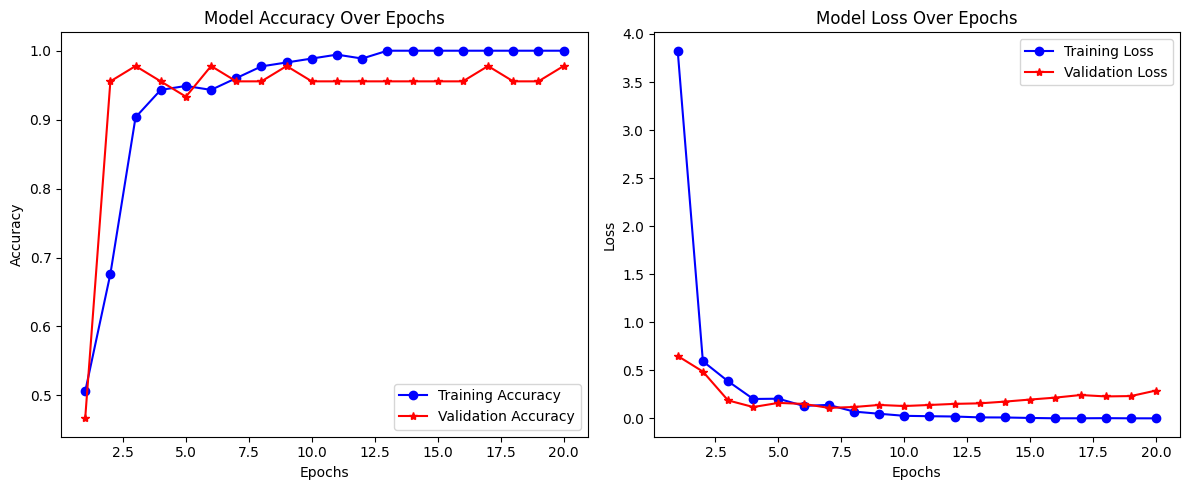

In [4]:
# ✅ Extract values from the history object
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

# 🔹 Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "bo-", label="Training Accuracy")
plt.plot(epochs, val_acc, "r*-", label="Validation Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# 🔹 Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo-", label="Training Loss")
plt.plot(epochs, val_loss, "r*-", label="Validation Loss")
plt.title("Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig(f"{model_name}_training_history.png")
plt.show()

In [3]:
import tensorflow as tf

model = tf.keras.models.load_model("cnn_v4_combined_model_v1.h5")
model.summary()

I0000 00:00:1746242000.883055    5415 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3929 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,838,660 (56.60 MB)

 Trainable params: 14,838,658 (56.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

AttributeError: 'Sequential' object has no attribute 'history'

In [4]:
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow import keras


# Optional: Suppress LIME console spam
class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, "w")
        sys.stderr = open(os.devnull, "w")

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr

In [ ]:
import os
import shutil

folder_path = "LIME_Explanations_Daniel/new_v4_combined/slic_pos_final"

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    # If it's a folder, remove it (and all contents) recursively
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)

print(f"All files and folders in '{folder_path}' have been deleted.")

All files and folders in 'LIME_Explanations_Daniel/new_v4_combined/slic_pos_final' have been deleted.


In [6]:
def mask_average(class_dir):
    accumulated_mask = np.zeros((256, 256))
    image_count = 0
    # Accumulate mask data
    for fname in os.listdir(class_dir):
        if fname.startswith("Mask") and fname.endswith(".png"):
            mask_path = os.path.join(class_dir, fname)
            mask = plt.imread(mask_path)
            if mask.ndim == 3:
                mask = mask[:, :, 0]
            if mask.shape != (256, 256):
                continue
            accumulated_mask += mask
            image_count += 1

    avg_mask = accumulated_mask / image_count if image_count > 0 else np.zeros((256, 256))

    return avg_mask, image_count


def lime_class_heatmaps(output_dir):
    print(f"Output Directory: {output_dir}")
    print(f"Has Classes: {os.listdir(output_dir)}")

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    for i, lime_class in enumerate(os.listdir(output_dir)):

        # Check if it's a directory
        class_dir = os.path.join(output_dir, lime_class)
        #print(f"Class Directory: {class_dir}")

        avg_mask, image_count = mask_average(class_dir)
        
        # Average mask
        if image_count > 0:
            cbar = fig.colorbar(ax[i].imshow(avg_mask, cmap="inferno"), ax=ax[i])
            cbar.set_label("Average Importance Score")
            ax[i].set_title(f"Average Mask - {lime_class} ({image_count} images)")
            ax[i].axis("off")
  
        else:
            print(f"No valid masks found for {lime_class}")

    #plt.tight_layout()
    plt.suptitle(f"LIME Heatmap - Combined\n{output_dir}")
    plt.savefig(os.path.join("/home/maxwell/lime", f"{output_dir}lime_heatmap.png"), dpi=300) 
    plt.show()
        


# Define prediction function for LIME
def predict_fn(images):
    images = images.astype("float32") / 255.0
    # Convert RGB to grayscale (LIME uses RGB)
    images = np.mean(images, axis=-1, keepdims=True)  # Shape becomes (batch, 256, 256, 1)

    # preds = model.predict(images)
    # print(f"{preds}")
    # fig, ax = plt.subplots(2,5, figsize=(8,6))
    # for i in range(10):
    #     ax[i//5, i%5].imshow(images[i])
    #     ax[i//5, i%5].axis('off')
    #     #ax[i//5, i%5].set_title(f"Pred: {round(preds[i],3)}")
    # plt.tight_layout()
    # plt.show()

    with tf.device("/GPU:0"):  # Optional, for forcing GPU
        return model.predict(images, verbose=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 12.011 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 1 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.552 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 2 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.575 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 3 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.884 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 4 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.652 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 5 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.757 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 6 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.704 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 7 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.872 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 8 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.531 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 9 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.710 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 10 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.643 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 11 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.496 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 12 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.633 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 13 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.544 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 14 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.311 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 15 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.467 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 16 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.814 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 17 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.396 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 18 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.479 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 19 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.333 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 20 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.472 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 21 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.293 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 22 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.312 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 23 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.605 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 24 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.368 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 25 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.336 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 26 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.092 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 27 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.202 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 28 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.237 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 29 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.509 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 30 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.412 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 31 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.099 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 32 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.228 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 33 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.280 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 34 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.114 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 35 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.382 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 36 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.003 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 37 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.187 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 38 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.157 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 39 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 12.027 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 40 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.508 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 41 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.900 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 42 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.715 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 43 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.651 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 44 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.615 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 45 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.773 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 46 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.799 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 47 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.900 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 48 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.582 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 49 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.543 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 50 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.468 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 51 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.618 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 52 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.536 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 53 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.491 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 54 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.598 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 55 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.362 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 56 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.449 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 57 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.519 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 58 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.346 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 59 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.258 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 60 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.486 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 61 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.294 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 62 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.249 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 63 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.171 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 64 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.863 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 65 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.155 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 66 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.900 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 67 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.921 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 68 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.928 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 69 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.732 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 70 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.698 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 71 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.693 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 72 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.604 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 73 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.734 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 74 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.663 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 75 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.606 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 76 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.599 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 77 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.500 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 78 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.410 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 79 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.321 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 80 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.171 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 81 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.201 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 82 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.106 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 83 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.217 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 84 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.406 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 85 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.282 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 86 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.175 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 87 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.145 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 88 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.068 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 89 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.138 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 90 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.095 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 91 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.037 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 92 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.197 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 93 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.918 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 94 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.917 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 95 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.134 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 96 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.991 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 97 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.833 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 98 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.098 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.025 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 100 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.928 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 101 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.873 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 102 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.963 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 103 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.772 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 104 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.000 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 105 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.848 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 106 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.851 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 107 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.697 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 108 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.785 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 109 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.773 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 110 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.999 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 111 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.652 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 112 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.700 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 113 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.698 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 114 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.751 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 115 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.597 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 116 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.594 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 117 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.785 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 118 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.416 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 119 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.190 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 120 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.076 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 121 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.132 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 122 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.523 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 123 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.309 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 124 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.249 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 125 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.173 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 126 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.239 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 127 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.026 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 128 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.225 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 129 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.434 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 130 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.946 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 131 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.938 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 132 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.045 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 133 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.762 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 134 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.886 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 135 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.243 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 136 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.943 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 137 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.936 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 138 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.820 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 139 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.056 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 140 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.943 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 141 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.930 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 142 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.841 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 143 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.903 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 144 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.917 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 145 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.756 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 146 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.901 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 147 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.917 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 148 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.900 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 149 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.800 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 150 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.702 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 151 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.733 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 152 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.719 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 153 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.720 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 154 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.934 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 155 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.757 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 156 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.671 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 157 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.555 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 158 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.347 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 159 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.309 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 160 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.273 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 161 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.082 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 162 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.126 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 163 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.183 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 164 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.432 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 165 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.310 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 166 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.267 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 167 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.903 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 168 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.932 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 169 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.997 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 170 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.143 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 171 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.192 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 172 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.070 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 173 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.890 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 174 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.905 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 175 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.029 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 176 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.088 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 177 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.832 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 178 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.148 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 179 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.886 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 180 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.802 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 181 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.796 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 182 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.844 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 183 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.799 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 184 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.047 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 185 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.921 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 186 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.712 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 187 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.644 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 188 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.804 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 189 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.696 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 190 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.908 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 191 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.824 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 192 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.831 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 193 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.795 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 194 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.743 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 195 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.763 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 196 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.806 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 197 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.757 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 198 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.468 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 199 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.132 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 200 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.094 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 201 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.237 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 202 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.505 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 203 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.297 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 204 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.127 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 205 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.208 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 206 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.026 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 207 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.146 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 208 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.304 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 209 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.059 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 210 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.094 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 211 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.271 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 212 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.898 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 213 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.990 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 214 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.036 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 215 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.966 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 216 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.799 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 217 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.936 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 218 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.807 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 219 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.716 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Iteration 220 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.690 seconds
Output Directory: LIME_Explanations_Daniel/new_v4_combined/slic_pos_final/methodslic_n_segments100_compactness10_enforce_connectivityTrue_hideColor255
Has Classes: ['Class_0', 'Class_1']


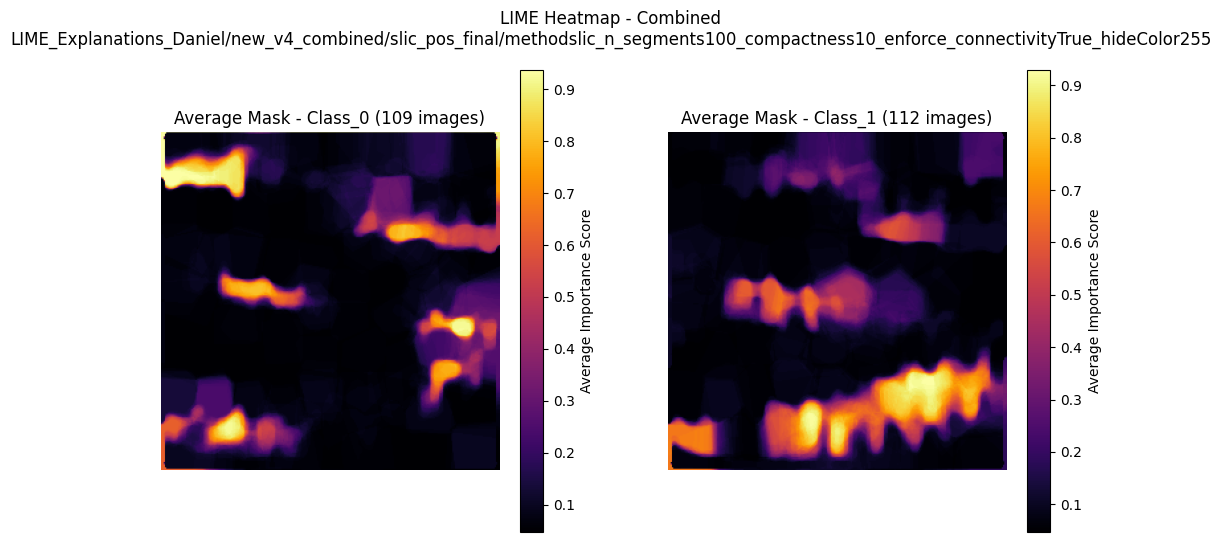

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.942 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 1 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.824 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 2 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.843 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 3 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.912 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 4 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.852 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 5 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.928 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 6 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.074 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 7 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.041 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 8 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.838 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 9 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.970 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 10 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.139 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 11 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.939 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 12 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.915 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 13 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.727 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 14 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.792 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 15 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.422 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 16 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.223 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 17 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.143 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 18 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.616 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 19 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.569 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 20 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.251 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 21 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.250 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 22 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.593 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 23 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.255 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 24 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.185 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 25 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.309 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 26 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.079 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 27 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.329 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 28 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.082 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 29 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.052 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 30 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.211 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 31 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.056 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 32 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.948 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 33 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.325 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 34 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.963 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 35 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.790 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 36 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.917 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 37 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.359 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 38 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.184 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 39 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.053 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 40 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.861 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 41 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.225 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 42 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.023 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 43 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.760 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 44 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.743 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 45 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.947 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 46 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.517 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 47 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.972 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 48 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.773 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 49 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.888 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 50 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.103 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 51 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.789 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 52 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.620 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 53 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.790 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 54 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.716 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 55 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.876 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 56 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.397 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 57 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.214 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 58 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.324 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 59 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.130 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 60 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.353 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 61 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.261 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 62 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.305 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 63 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.205 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 64 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.484 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 65 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.286 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 66 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.323 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 67 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.073 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 68 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.117 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 69 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.349 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 70 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.284 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 71 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.062 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 72 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.845 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 73 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.174 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 74 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.987 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 75 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.808 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 76 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.756 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 77 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.967 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 78 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.882 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 79 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.803 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 80 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.843 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 81 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.934 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 82 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.891 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 83 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.811 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 84 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.954 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 85 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.699 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 86 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.912 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 87 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.738 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 88 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.790 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 89 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.885 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 90 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.796 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 91 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.712 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 92 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.687 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 93 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.762 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 94 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.697 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 95 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.689 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 96 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.155 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 97 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.168 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 98 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.109 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.260 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 100 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.215 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 101 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.264 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 102 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.412 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 103 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.212 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 104 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.209 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 105 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.330 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 106 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.165 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 107 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.085 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 108 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.064 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 109 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.194 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 110 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.325 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 111 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.966 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 112 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.955 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 113 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.164 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 114 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.052 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 115 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.055 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 116 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.796 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 117 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.888 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 118 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.902 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 119 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.031 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 120 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.860 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 121 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.904 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 122 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.051 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 123 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.986 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 124 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.824 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 125 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.020 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 126 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.861 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 127 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.874 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 128 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.769 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 129 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.865 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 130 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.871 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 131 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.647 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 132 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.830 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 133 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.906 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 134 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.692 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 135 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.812 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 136 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.616 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 137 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.454 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 138 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.255 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 139 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.423 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 140 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.278 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 141 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.341 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 142 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.259 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 143 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.349 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 144 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.158 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 145 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.256 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 146 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.382 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 147 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.977 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 148 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.169 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 149 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.272 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 150 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.090 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 151 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.953 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 152 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.974 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 153 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.079 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 154 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.086 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 155 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.124 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 156 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.890 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 157 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.042 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 158 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.955 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 159 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.940 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 160 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.866 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 161 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.739 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 162 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.863 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 163 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.808 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 164 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.134 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 165 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.072 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 166 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.887 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 167 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.781 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 168 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.620 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 169 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.835 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 170 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.861 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 171 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.891 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 172 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.653 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 173 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.883 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 174 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.657 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 175 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.822 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 176 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.642 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 177 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.596 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 178 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.541 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 179 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.293 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 180 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.146 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 181 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.142 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 182 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.256 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 183 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.294 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 184 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.294 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 185 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.425 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 186 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.247 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 187 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.129 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 188 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.083 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 189 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.078 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 190 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.221 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 191 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.265 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 192 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.115 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 193 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.264 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 194 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.163 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 195 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.192 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 196 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.933 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 197 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.038 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 198 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.115 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 199 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.841 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 200 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.837 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 201 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.947 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 202 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.049 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 203 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.978 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 204 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.867 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 205 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.841 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 206 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.785 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 207 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.818 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 208 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.878 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 209 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.784 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 210 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.949 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 211 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.016 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 212 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.921 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 213 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.809 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 214 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.890 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 215 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.703 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 216 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.729 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 217 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.669 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 218 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.722 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 219 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.324 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Iteration 220 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.042 seconds
Output Directory: LIME_Explanations_Daniel/new_v4_combined/slic_pos_final/methodslic_n_segments200_compactness10_enforce_connectivityTrue_hideColor255
Has Classes: ['Class_0', 'Class_1']


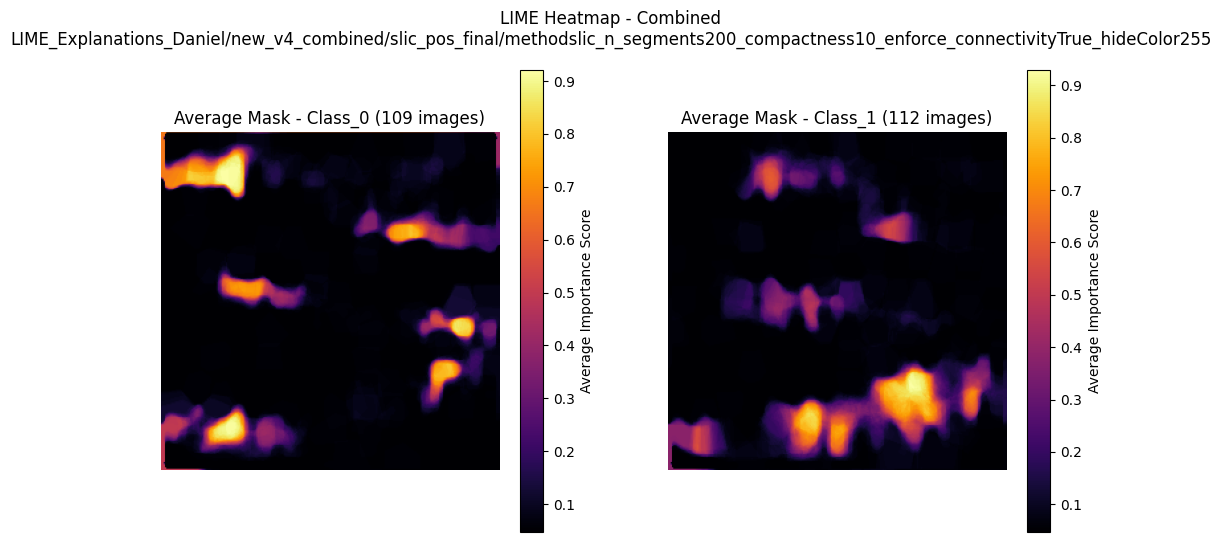

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.495 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 1 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.328 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 2 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.193 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 3 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.602 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 4 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.087 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 5 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.426 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 6 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.340 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 7 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.435 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 8 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.092 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 9 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.385 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 10 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.049 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 11 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.947 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 12 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.312 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 13 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.150 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 14 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.909 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 15 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.287 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 16 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.042 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 17 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.999 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 18 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.096 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 19 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.785 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 20 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.123 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 21 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.922 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 22 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.184 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 23 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.721 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 24 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.081 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 25 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.196 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 26 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.803 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 27 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.748 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 28 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.922 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 29 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.558 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 30 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.911 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 31 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.571 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 32 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.819 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 33 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.995 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 34 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.829 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 35 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.553 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 36 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.761 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 37 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.471 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 38 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.456 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 39 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.278 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 40 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.068 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 41 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.721 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 42 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.618 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 43 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.184 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 44 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.298 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 45 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.408 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 46 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.327 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 47 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.442 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 48 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.181 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 49 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.254 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 50 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.393 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 51 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.081 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 52 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.019 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 53 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.069 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 54 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.125 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 55 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.948 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 56 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.982 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 57 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.991 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 58 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.167 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 59 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.942 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 60 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.871 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 61 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.765 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 62 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.798 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 63 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.920 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 64 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.108 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 65 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.227 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 66 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.239 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 67 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.871 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 68 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.915 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 69 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.107 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 70 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.042 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 71 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.729 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 72 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.666 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 73 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.784 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 74 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.743 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 75 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.907 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 76 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.723 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 77 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.666 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 78 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.005 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 79 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.483 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 80 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.308 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 81 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.334 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 82 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.142 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 83 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.265 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 84 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.525 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 85 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.288 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 86 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.182 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 87 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.159 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 88 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.468 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 89 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.406 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 90 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.196 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 91 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.960 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 92 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.051 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 93 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.199 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 94 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.919 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 95 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.111 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 96 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.238 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 97 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.965 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 98 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.890 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.061 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 100 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.130 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 101 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.930 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 102 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.174 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 103 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.832 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 104 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.972 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 105 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.915 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 106 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.903 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 107 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.748 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 108 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.651 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 109 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.884 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 110 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.066 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 111 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.604 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 112 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.042 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 113 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.134 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 114 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.067 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 115 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.995 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 116 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.831 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 117 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.545 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 118 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.940 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 119 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.790 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 120 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.639 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 121 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.349 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 122 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.300 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 123 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.018 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 124 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.281 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 125 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.524 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 126 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.399 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 127 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.618 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 128 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.466 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 129 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.503 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 130 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.253 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 131 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.985 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 132 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.331 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 133 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.136 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 134 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.083 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 135 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.305 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 136 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.052 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 137 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.227 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 138 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.064 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 139 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.305 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 140 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.117 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 141 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.030 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 142 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.996 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 143 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.321 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 144 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.958 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 145 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.068 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 146 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.267 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 147 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.784 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 148 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.003 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 149 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.187 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 150 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.909 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 151 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.116 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 152 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.968 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 153 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.926 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 154 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.043 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 155 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.241 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 156 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.045 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 157 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.817 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 158 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.812 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 159 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.892 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 160 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.647 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 161 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.863 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 162 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.344 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 163 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.206 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 164 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.761 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 165 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.644 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 166 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.045 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 167 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.369 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 168 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.089 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 169 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.496 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 170 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.447 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 171 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.380 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 172 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.125 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 173 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.387 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 174 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.124 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 175 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.310 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 176 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.303 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 177 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.124 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 178 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.222 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 179 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.432 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 180 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.829 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 181 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.823 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 182 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.061 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 183 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.090 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 184 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.144 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 185 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.218 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 186 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.955 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 187 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.959 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 188 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.768 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 189 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.955 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 190 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.007 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 191 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.111 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 192 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.085 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 193 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.113 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 194 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.116 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 195 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.045 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 196 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.757 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 197 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.056 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 198 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.170 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 199 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.934 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 200 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.784 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 201 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.983 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 202 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.187 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 203 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.876 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 204 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.501 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 205 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.118 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 206 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.063 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 207 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.391 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 208 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.442 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 209 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.318 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 210 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.465 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 211 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.439 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 212 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.409 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 213 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.197 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 214 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.346 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 215 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.188 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 216 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.112 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 217 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.062 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 218 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.157 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 219 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 12.976 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Iteration 220 with setting methodslic_n_segments300_compactness10_enforce_connectivityTrue and hide_color 255 took 13.097 seconds
Output Directory: LIME_Explanations_Daniel/new_v4_combined/slic_pos_final/methodslic_n_segments300_compactness10_enforce_connectivityTrue_hideColor255
Has Classes: ['Class_0', 'Class_1']


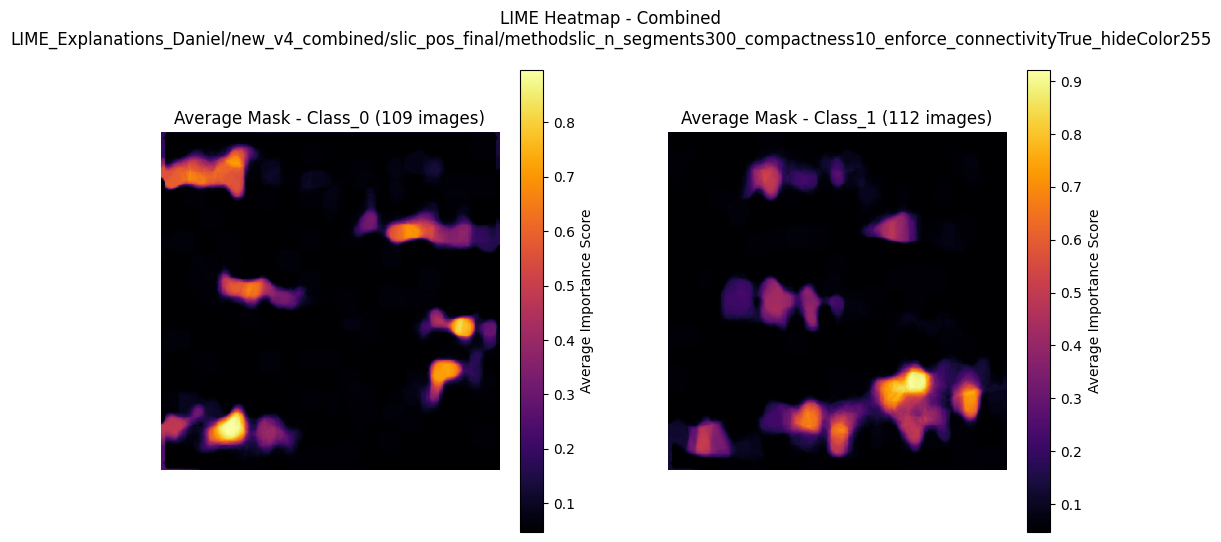

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.258 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 1 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.378 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 2 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.355 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 3 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.257 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 4 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.208 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 5 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.159 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 6 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.247 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 7 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.206 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 8 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.175 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 9 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.180 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 10 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.139 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 11 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.208 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 12 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.212 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 13 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.183 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 14 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.120 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 15 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.101 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 16 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.022 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 17 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.094 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 18 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.109 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 19 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.054 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 20 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.149 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 21 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.106 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 22 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 10.986 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 23 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.584 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 24 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.553 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 25 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.460 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 26 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.439 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 27 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.546 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 28 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.602 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 29 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.676 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 30 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.602 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 31 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.513 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 32 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.474 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 33 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.448 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 34 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.418 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 35 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.495 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 36 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.501 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 37 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.469 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 38 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.387 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 39 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.298 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 40 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.309 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 41 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.378 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 42 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.337 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 43 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.307 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 44 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.243 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 45 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.255 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 46 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.240 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 47 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.282 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 48 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.169 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 49 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.226 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 50 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.295 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 51 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.164 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 52 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.209 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 53 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.316 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 54 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.091 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 55 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.140 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 56 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.107 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 57 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.119 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 58 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.062 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 59 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.091 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 60 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.037 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 61 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.084 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 62 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 10.998 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 63 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.049 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 64 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.046 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 65 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.041 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 66 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.045 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 67 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.512 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 68 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.469 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 69 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.571 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 70 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.682 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 71 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.605 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 72 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.647 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 73 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.534 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 74 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.529 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 75 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.492 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 76 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.481 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 77 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.438 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 78 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.453 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 79 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.574 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 80 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.422 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 81 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.380 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 82 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.305 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 83 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.338 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 84 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.367 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 85 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.327 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 86 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.260 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 87 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.340 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 88 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.331 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 89 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.273 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 90 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.196 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 91 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.192 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 92 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.164 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 93 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.175 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 94 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.212 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 95 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.109 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 96 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.234 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 97 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.171 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 98 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.068 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.122 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 100 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.019 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 101 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.041 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 102 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.058 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 103 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 10.995 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 104 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.039 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 105 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.179 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 106 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 10.978 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 107 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 10.983 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 108 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.881 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 109 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.534 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 110 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.542 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 111 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.451 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 112 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.576 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 113 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.719 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 114 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.621 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 115 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.557 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 116 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.526 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 117 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.509 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 118 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.478 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 119 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.504 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 120 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.485 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 121 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.431 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 122 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.502 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 123 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.293 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 124 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.390 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 125 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.366 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 126 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.361 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 127 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.276 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 128 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.302 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 129 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.305 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 130 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.337 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 131 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.223 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 132 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.214 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 133 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.258 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 134 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.194 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 135 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.155 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 136 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.239 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 137 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.148 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 138 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.165 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 139 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.123 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 140 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.219 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 141 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.156 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 142 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.101 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 143 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.142 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 144 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.067 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 145 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.011 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 146 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.056 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 147 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.099 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 148 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.029 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 149 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.013 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 150 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.546 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 151 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.486 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 152 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.540 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 153 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.491 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 154 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.554 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 155 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.704 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 156 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.654 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 157 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.630 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 158 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.516 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 159 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.539 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 160 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.427 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 161 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.409 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 162 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.440 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 163 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.423 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 164 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.411 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 165 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.387 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 166 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.280 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 167 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.294 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 168 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.328 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 169 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.233 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 170 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.385 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 171 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.264 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 172 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.137 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 173 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.222 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 174 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.251 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 175 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.185 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 176 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.186 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 177 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.244 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 178 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.211 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 179 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.156 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 180 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.101 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 181 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.113 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 182 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.147 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 183 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.065 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 184 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.136 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 185 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.025 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 186 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.035 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 187 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.099 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 188 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 10.986 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 189 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.048 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 190 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.013 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 191 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.075 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 192 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 10.979 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 193 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.747 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 194 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.447 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 195 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.518 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 196 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.478 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 197 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.489 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 198 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.636 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 199 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.662 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 200 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.619 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 201 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.563 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 202 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.460 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 203 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.354 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 204 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.450 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 205 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.404 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 206 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.389 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 207 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.353 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 208 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.436 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 209 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.351 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 210 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.325 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 211 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.343 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 212 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.332 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 213 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.235 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 214 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.249 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 215 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.268 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 216 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.243 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 217 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.204 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 218 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.139 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 219 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.175 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iteration 220 with setting methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 11.194 seconds
Output Directory: LIME_Explanations_Daniel/new_v4_combined/slic_pos_final/methodslic_n_segments100_compactness20_enforce_connectivityFalse_min_size_factor1.0_hideColor255
Has Classes: ['Class_0', 'Class_1']


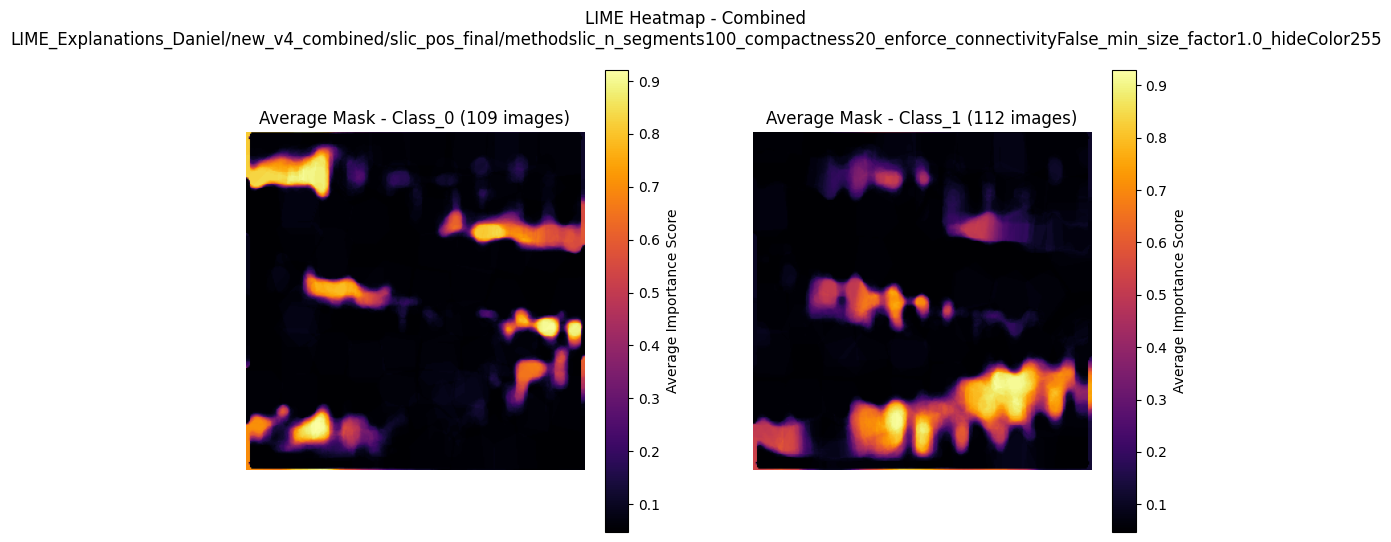

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.652 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 1 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.672 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 2 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.586 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 3 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.658 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 4 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.656 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 5 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.609 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 6 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.584 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 7 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.581 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 8 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.568 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 9 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.581 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 10 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.523 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 11 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.547 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 12 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.506 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 13 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.147 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 14 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.002 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 15 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.108 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 16 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.941 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 17 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.012 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 18 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.130 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 19 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.186 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 20 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.172 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 21 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.127 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 22 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.156 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 23 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.984 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 24 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.953 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 25 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.969 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 26 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.963 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 27 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.820 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 28 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.853 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 29 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.012 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 30 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.969 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 31 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.879 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 32 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.844 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 33 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.862 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 34 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.840 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 35 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.889 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 36 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.736 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 37 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.916 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 38 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.751 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 39 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.748 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 40 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.712 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 41 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.695 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 42 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.684 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 43 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.888 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 44 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.680 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 45 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.602 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 46 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.650 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 47 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.712 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 48 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.676 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 49 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.560 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 50 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.641 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 51 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.659 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 52 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.662 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 53 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.644 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 54 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.564 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 55 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.661 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 56 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.234 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 57 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.044 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 58 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.989 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 59 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.022 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 60 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.117 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 61 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.166 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 62 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.186 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 63 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.141 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 64 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.221 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 65 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.934 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 66 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.009 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 67 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.954 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 68 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.064 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 69 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.928 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 70 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.971 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 71 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.885 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 72 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.954 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 73 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.869 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 74 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.876 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 75 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.914 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 76 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.821 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 77 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.856 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 78 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.872 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 79 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.759 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 80 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.808 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 81 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.869 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 82 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.742 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 83 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.858 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 84 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.738 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 85 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.752 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 86 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.736 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 87 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.767 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 88 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.658 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 89 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.805 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 90 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.749 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 91 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.560 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 92 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.618 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 93 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.668 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 94 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.682 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 95 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.586 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 96 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.520 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 97 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.542 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 98 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.501 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.603 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 100 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.428 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 101 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.933 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 102 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.065 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 103 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.035 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 104 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.017 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 105 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.193 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 106 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.270 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 107 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.238 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 108 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.052 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 109 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.958 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 110 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.024 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 111 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.925 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 112 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.985 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 113 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.043 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 114 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.904 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 115 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.892 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 116 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.916 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 117 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.922 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 118 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.989 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 119 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.802 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 120 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.897 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 121 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.721 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 122 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.773 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 123 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.813 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 124 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.931 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 125 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.700 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 126 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.692 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 127 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.712 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 128 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.697 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 129 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.703 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 130 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.599 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 131 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.743 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 132 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.563 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 133 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.686 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 134 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.722 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 135 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.642 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 136 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.614 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 137 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.668 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 138 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.473 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 139 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.640 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 140 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.577 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 141 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.644 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 142 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.452 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 143 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.378 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 144 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.083 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 145 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.906 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 146 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.096 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 147 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.161 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 148 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.207 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 149 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.165 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 150 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.112 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 151 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.132 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 152 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.075 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 153 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.139 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 154 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.994 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 155 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.068 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 156 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.026 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 157 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.927 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 158 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.993 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 159 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.945 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 160 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.902 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 161 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.982 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 162 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.023 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 163 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.805 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 164 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.818 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 165 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.864 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 166 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.722 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 167 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.798 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 168 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.832 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 169 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.775 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 170 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.686 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 171 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.737 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 172 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.739 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 173 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.720 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 174 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.776 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 175 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.744 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 176 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.698 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 177 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.778 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 178 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.638 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 179 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.679 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 180 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.841 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 181 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.507 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 182 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.575 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 183 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.668 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 184 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.572 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 185 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.618 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 186 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.606 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 187 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.544 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 188 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.979 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 189 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.105 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 190 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.178 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 191 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.962 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 192 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.106 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 193 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.228 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 194 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.106 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 195 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.135 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 196 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.011 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 197 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.117 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 198 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.042 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 199 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.890 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 200 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.141 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 201 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.984 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 202 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.966 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 203 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.790 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 204 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.926 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 205 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.041 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 206 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.771 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 207 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.950 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 208 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.856 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 209 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.826 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 210 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.870 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 211 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.713 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 212 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.884 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 213 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.700 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 214 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.800 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 215 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.851 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 216 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.667 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 217 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.768 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 218 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.679 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 219 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.844 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Iteration 220 with setting methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 12.664 seconds
Output Directory: LIME_Explanations_Daniel/new_v4_combined/slic_pos_final/methodslic_n_segments200_compactness20_enforce_connectivityFalse_min_size_factor1.0_hideColor255
Has Classes: ['Class_0', 'Class_1']


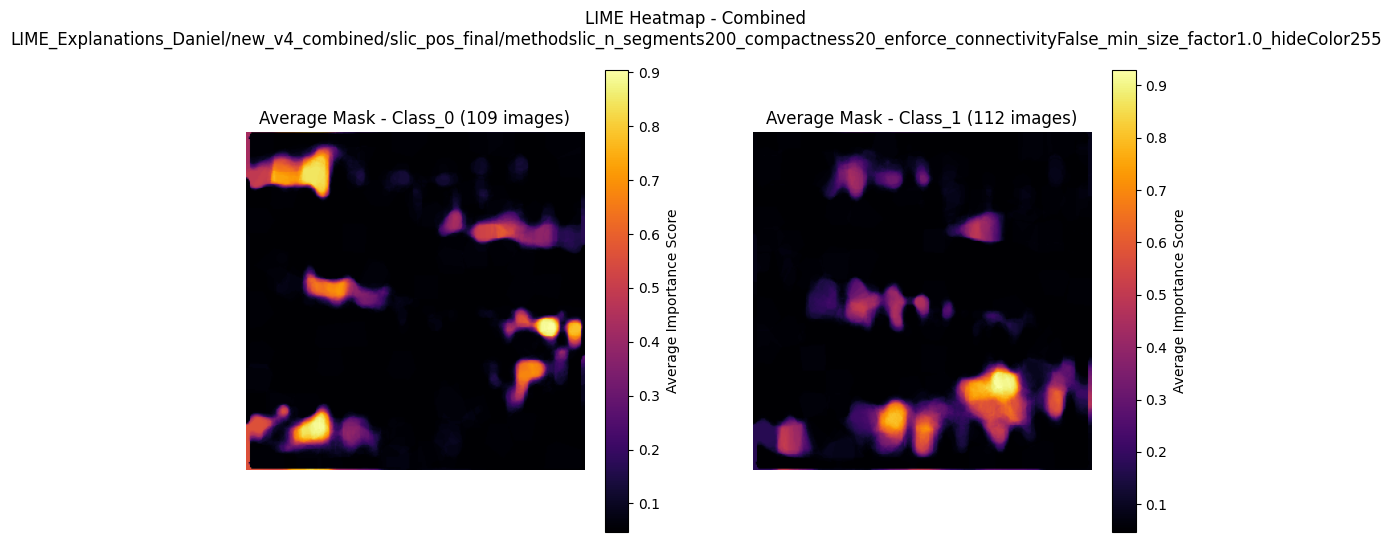

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.816 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 1 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.907 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 2 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.021 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 3 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.902 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 4 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.968 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 5 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.097 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 6 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.811 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 7 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.942 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 8 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.794 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 9 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.377 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 10 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.356 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 11 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.549 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 12 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.412 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 13 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.515 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 14 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.515 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 15 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.550 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 16 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.381 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 17 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.382 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 18 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.409 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 19 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.451 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 20 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.413 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 21 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.486 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 22 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.309 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 23 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.385 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 24 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.340 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 25 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.357 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 26 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.306 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 27 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.211 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 28 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.167 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 29 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.235 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 30 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.274 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 31 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.282 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 32 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.257 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 33 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.164 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 34 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.286 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 35 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.141 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 36 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.080 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 37 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.151 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 38 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.136 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 39 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.161 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 40 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.096 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 41 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.104 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 42 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.112 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 43 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.043 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 44 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.173 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 45 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.955 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 46 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.970 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 47 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.020 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 48 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.010 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 49 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.104 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 50 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.999 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 51 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.009 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 52 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 15.090 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 53 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.560 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 54 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.367 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 55 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.536 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 56 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.544 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 57 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.634 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 58 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.541 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 59 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.585 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 60 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.570 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 61 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.456 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 62 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.374 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 63 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.424 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 64 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.433 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 65 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.429 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 66 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.372 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 67 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.373 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 68 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.356 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 69 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.428 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 70 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.273 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 71 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.349 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 72 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.352 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 73 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.293 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 74 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.241 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 75 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.281 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 76 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.175 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 77 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.302 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 78 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.239 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 79 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.143 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 80 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.059 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 81 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.062 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 82 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.077 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 83 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.207 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 84 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.136 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 85 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.291 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 86 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.095 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 87 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.160 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 88 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.168 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 89 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.035 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 90 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.070 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 91 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.027 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 92 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.093 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 93 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.039 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 94 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.910 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 95 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.114 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 96 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.827 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 97 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.486 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 98 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.457 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.371 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 100 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.545 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 101 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.492 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 102 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.636 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 103 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.656 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 104 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.449 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 105 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.539 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 106 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.213 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 107 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.331 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 108 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.467 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 109 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.404 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 110 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.312 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 111 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.472 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 112 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.266 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 113 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.275 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 114 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.395 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 115 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.363 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 116 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.265 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 117 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.272 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 118 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.254 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 119 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.213 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 120 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.231 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 121 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.263 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 122 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.138 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 123 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.181 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 124 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.170 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 125 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.137 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 126 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.231 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 127 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.091 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 128 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.155 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 129 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.169 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 130 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.053 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 131 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.181 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 132 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.075 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 133 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.007 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 134 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.087 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 135 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.016 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 136 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.902 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 137 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.903 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 138 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.007 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 139 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.897 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 140 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.786 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 141 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.382 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 142 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.332 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 143 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.404 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 144 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.529 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 145 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.574 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 146 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.615 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 147 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.646 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 148 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.496 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 149 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.499 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 150 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.577 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 151 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.513 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 152 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.520 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 153 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.463 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 154 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.423 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 155 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.395 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 156 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.451 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 157 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.473 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 158 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.321 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 159 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.350 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 160 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.216 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 161 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.302 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 162 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.277 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 163 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.279 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 164 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.178 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 165 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.201 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 166 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.145 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 167 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.148 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 168 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.205 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 169 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.137 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 170 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.176 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 171 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.120 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 172 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.108 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 173 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.049 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 174 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.180 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 175 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.161 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 176 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.073 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 177 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.134 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 178 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.021 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 179 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.095 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 180 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.074 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 181 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.945 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 182 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.036 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 183 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.059 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 184 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 13.894 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 185 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 15.012 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 186 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.302 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 187 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.617 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 188 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.558 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 189 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.455 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 190 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.511 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 191 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.626 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 192 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.581 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 193 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.442 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 194 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.548 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 195 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.478 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 196 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.392 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 197 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.408 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 198 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.481 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 199 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.492 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 200 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.334 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 201 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.273 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 202 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.339 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 203 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.568 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 204 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.313 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 205 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.177 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 206 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.230 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 207 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.329 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 208 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.201 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 209 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.228 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 210 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.136 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 211 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.066 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 212 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.254 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 213 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.233 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 214 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.193 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 215 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.225 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 216 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.058 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 217 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.146 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 218 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.128 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 219 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.005 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iteration 220 with setting methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0 and hide_color 255 took 14.132 seconds
Output Directory: LIME_Explanations_Daniel/new_v4_combined/slic_pos_final/methodslic_n_segments300_compactness20_enforce_connectivityFalse_min_size_factor1.0_hideColor255
Has Classes: ['Class_0', 'Class_1']


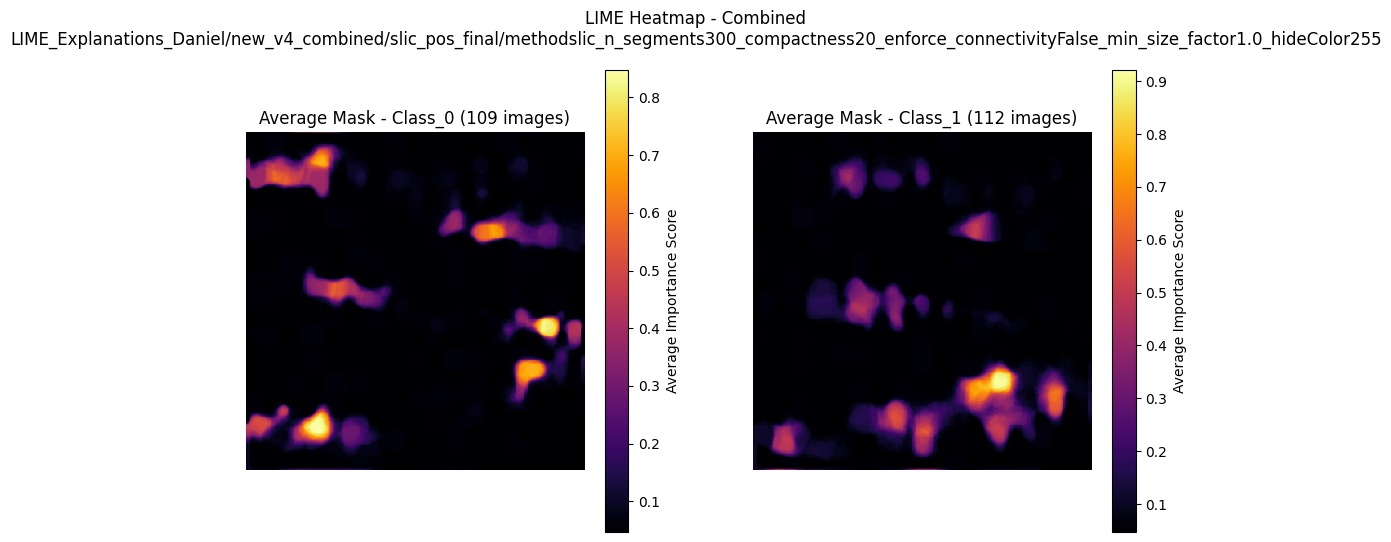

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.705 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 1 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.562 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 2 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.512 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 3 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.459 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 4 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.485 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 5 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.689 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 6 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.651 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 7 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.545 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 8 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.920 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 9 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.032 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 10 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.033 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 11 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.923 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 12 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.117 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 13 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.120 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 14 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.003 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 15 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.996 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 16 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.045 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 17 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.973 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 18 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.042 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 19 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.874 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 20 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.966 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 21 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.848 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 22 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.813 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 23 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.904 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 24 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.866 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 25 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.907 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 26 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.757 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 27 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.931 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 28 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.755 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 29 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.710 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 30 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.801 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 31 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.679 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 32 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.667 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 33 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.746 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 34 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.731 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 35 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.604 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 36 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.643 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 37 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.831 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 38 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.767 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 39 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.605 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 40 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.601 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 41 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.635 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 42 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.763 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 43 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.631 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 44 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.587 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 45 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.589 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 46 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.564 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 47 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.647 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 48 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.521 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 49 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.655 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 50 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.584 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 51 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.005 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 52 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.960 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 53 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.022 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 54 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.055 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 55 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.950 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 56 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.084 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 57 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.167 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 58 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.267 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 59 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.966 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 60 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.013 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 61 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.056 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 62 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.943 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 63 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.779 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 64 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.075 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 65 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.966 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 66 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.930 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 67 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.984 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 68 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.981 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 69 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.850 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 70 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.850 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 71 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.758 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 72 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.701 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 73 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.856 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 74 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.732 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 75 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.773 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 76 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.726 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 77 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.729 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 78 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.743 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 79 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.646 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 80 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.635 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 81 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.755 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 82 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.741 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 83 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.698 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 84 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.655 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 85 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.843 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 86 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.634 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 87 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.568 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 88 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.648 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 89 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.746 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 90 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.540 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 91 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.564 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 92 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.467 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 93 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.482 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 94 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.476 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 95 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.607 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 96 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.204 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 97 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.069 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 98 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.892 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.130 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 100 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.915 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 101 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.087 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 102 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.087 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 103 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.130 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 104 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.163 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 105 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.006 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 106 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.079 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 107 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.838 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 108 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.922 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 109 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.112 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 110 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.982 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 111 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.904 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 112 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.889 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 113 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.877 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 114 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.988 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 115 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.872 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 116 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.884 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 117 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.802 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 118 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.817 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 119 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.755 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 120 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.806 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 121 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.729 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 122 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.750 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 123 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.812 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 124 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.648 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 125 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.756 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 126 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.721 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 127 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.690 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 128 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.574 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 129 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.705 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 130 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.603 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 131 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.609 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 132 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.698 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 133 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.621 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 134 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.734 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 135 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.518 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 136 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.571 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 137 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.531 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 138 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.563 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 139 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.680 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 140 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.505 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 141 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.455 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 142 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.583 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 143 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.101 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 144 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.010 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 145 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.062 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 146 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.164 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 147 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.118 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 148 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.157 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 149 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.219 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 150 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.026 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 151 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.943 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 152 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.004 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 153 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.950 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 154 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.061 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 155 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.990 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 156 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.954 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 157 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.863 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 158 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.903 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 159 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.915 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 160 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.738 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 161 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.942 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 162 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.770 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 163 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.823 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 164 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.813 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 165 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.764 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 166 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.819 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 167 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.734 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 168 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.674 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 169 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.724 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 170 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.746 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 171 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.757 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 172 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.647 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 173 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.851 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 174 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.584 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 175 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.699 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 176 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.629 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 177 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.636 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 178 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.724 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 179 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.548 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 180 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.525 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 181 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.598 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 182 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.555 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 183 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.454 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 184 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.601 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 185 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.464 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 186 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.348 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 187 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.298 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 188 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.132 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 189 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.020 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 190 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.972 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 191 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.108 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 192 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.073 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 193 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.184 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 194 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.058 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 195 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.132 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 196 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.882 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 197 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.998 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 198 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.999 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 199 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.931 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 200 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.943 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 201 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.930 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 202 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.076 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 203 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.004 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 204 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.816 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 205 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.844 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 206 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.728 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 207 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.955 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 208 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.875 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 209 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.906 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 210 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.793 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 211 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.919 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 212 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.774 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 213 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.786 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 214 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.803 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 215 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.794 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 216 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.661 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 217 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.679 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 218 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.617 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 219 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.591 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Iteration 220 with setting methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 10.736 seconds
Output Directory: LIME_Explanations_Daniel/new_v4_combined/slic_pos_final/methodslic_n_segments100_compactness20_enforce_connectivityTrue_min_size_factor1.0_hideColor255
Has Classes: ['Class_0', 'Class_1']


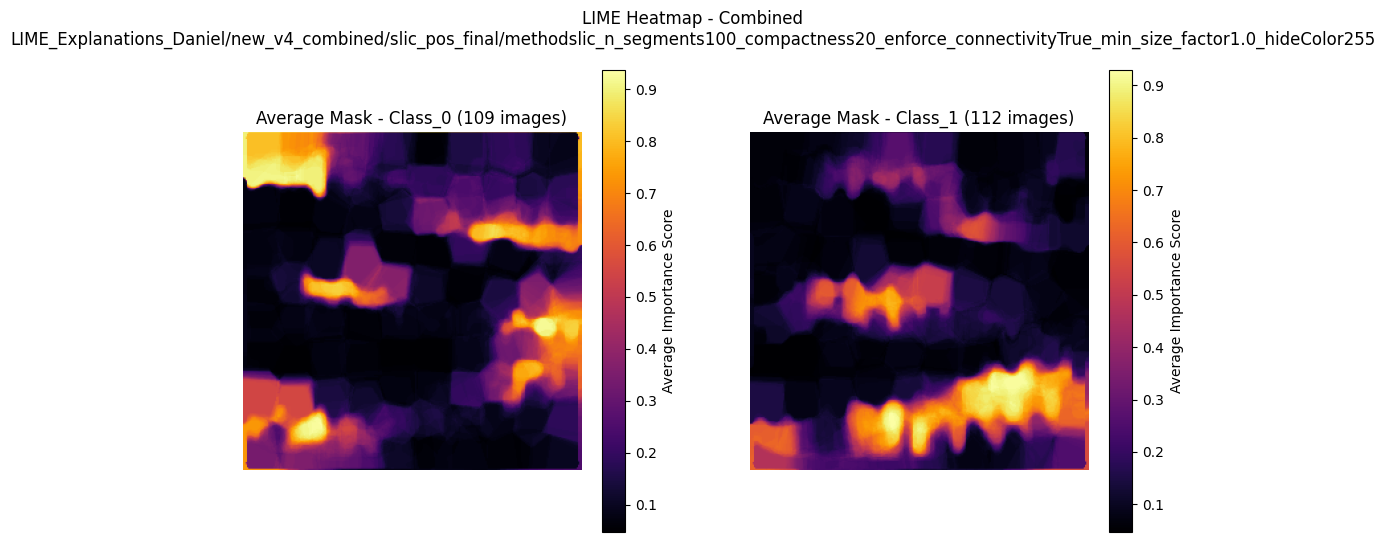

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.698 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 1 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.778 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 2 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.457 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 3 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.675 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 4 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.535 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 5 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.854 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 6 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.570 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 7 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.710 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 8 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.624 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 9 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.348 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 10 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.459 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 11 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.039 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 12 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.142 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 13 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.083 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 14 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.249 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 15 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.242 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 16 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.285 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 17 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.227 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 18 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.404 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 19 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.914 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 20 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.899 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 21 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.020 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 22 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.095 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 23 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.239 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 24 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.796 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 25 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.189 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 26 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.968 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 27 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.816 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 28 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.932 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 29 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.863 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 30 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.855 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 31 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.970 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 32 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.766 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 33 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.790 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 34 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.843 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 35 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.729 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 36 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.791 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 37 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.791 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 38 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.903 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 39 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.661 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 40 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.772 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 41 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.521 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 42 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.645 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 43 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.776 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 44 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.710 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 45 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.832 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 46 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.808 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 47 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.715 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 48 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.697 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 49 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.965 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 50 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.590 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 51 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.688 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 52 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.701 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 53 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.719 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration 54 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.689 seconds


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 55 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.537 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 56 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.584 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 57 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.086 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 58 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.252 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 59 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.020 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 60 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.181 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 61 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.202 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 62 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.128 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 63 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.254 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 64 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.128 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 65 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.186 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 66 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.319 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 67 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.006 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 68 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.061 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 69 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.034 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 70 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.001 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 71 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.044 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 72 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.925 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 73 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.918 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 74 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.038 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 75 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.898 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 76 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.914 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 77 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.930 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 78 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.054 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 79 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.746 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 80 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.966 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 81 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.871 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 82 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.925 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 83 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.812 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 84 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.975 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 85 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.759 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 86 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.913 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 87 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.801 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 88 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.816 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 89 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.826 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 90 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.823 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 91 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.719 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 92 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.789 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 93 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.662 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 94 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.781 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 95 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.785 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 96 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.686 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 97 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.676 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 98 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.684 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.574 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 100 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.648 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 101 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.519 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 102 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.646 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 103 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.245 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 104 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.923 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 105 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.180 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 106 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.145 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 107 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.069 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 108 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.273 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 109 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.298 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 110 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.347 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 111 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.941 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 112 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.133 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 113 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.068 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 114 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.056 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 115 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.264 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 116 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.126 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 117 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.946 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 118 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.086 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 119 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.064 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 120 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.943 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 121 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.002 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 122 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.989 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 123 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.923 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 124 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.958 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 125 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.825 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 126 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.018 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 127 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.864 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 128 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.870 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Iteration 129 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.020 seconds


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 130 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.896 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 131 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.718 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 132 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.946 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 133 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.913 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 134 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.711 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 135 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.785 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 136 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.761 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 137 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.967 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 138 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.827 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 139 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.730 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 140 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.881 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 141 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.756 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 142 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.701 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 143 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.761 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 144 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.589 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 145 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.684 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 146 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.850 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 147 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.652 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 148 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.796 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 149 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.988 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 150 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.000 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 151 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.094 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 152 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.034 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 153 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.172 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 154 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.163 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 155 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.086 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 156 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.167 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 157 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.157 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 158 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.126 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 159 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.012 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 160 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.154 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 161 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.126 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 162 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.203 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 163 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.922 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 164 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.816 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 165 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.919 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 166 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.986 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 167 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.876 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 168 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.035 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 169 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.890 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 170 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.905 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 171 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.041 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 172 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.969 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 173 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.803 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 174 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.836 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 175 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.920 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 176 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.892 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 177 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.704 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 178 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.107 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 179 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.460 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 180 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.861 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 181 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.628 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 182 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.907 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 183 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.644 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 184 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.761 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 185 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.701 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 186 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.738 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 187 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.668 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 188 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.702 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 189 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.628 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 190 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.573 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 191 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.796 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 192 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.700 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 193 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.662 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 194 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.780 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 195 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.107 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 196 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.229 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 197 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.061 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 198 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.382 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 199 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.290 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 200 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.131 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 201 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.352 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 202 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.336 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 203 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.175 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 204 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.080 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 205 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.028 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 206 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.139 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 207 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.027 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 208 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.396 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 209 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.046 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 210 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.138 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 211 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.024 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 212 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.111 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 213 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.026 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 214 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.168 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 215 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.074 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 216 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.972 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 217 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.009 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 218 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.050 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 219 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.057 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Iteration 220 with setting methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 11.933 seconds
Output Directory: LIME_Explanations_Daniel/new_v4_combined/slic_pos_final/methodslic_n_segments200_compactness20_enforce_connectivityTrue_min_size_factor1.0_hideColor255
Has Classes: ['Class_0', 'Class_1']


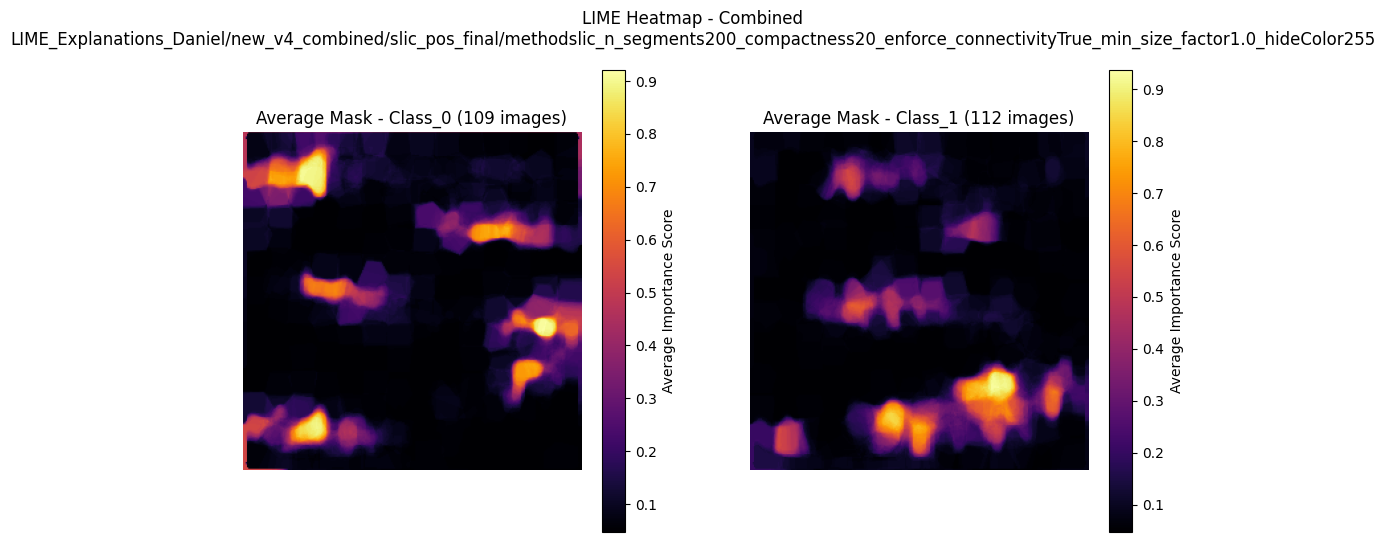

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.977 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 1 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.991 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 2 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.875 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 3 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.029 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 4 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.719 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 5 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.030 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 6 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.092 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 7 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.841 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 8 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.639 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 9 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.025 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 10 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.923 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 11 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.892 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 12 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.032 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 13 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.785 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 14 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.854 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 15 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.877 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 16 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.880 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 17 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.835 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 18 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.648 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 19 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.297 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 20 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.080 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 21 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.413 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 22 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.308 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 23 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.455 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 24 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.091 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 25 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.259 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 26 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.088 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 27 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.221 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 28 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.113 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 29 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.276 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 30 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.969 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 31 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.105 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 32 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.001 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 33 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.223 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 34 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.887 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 35 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.874 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 36 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.053 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 37 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.315 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 38 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.993 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 39 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.050 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 40 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.780 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 41 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.392 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 42 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.984 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 43 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.123 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 44 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.889 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 45 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.968 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 46 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.749 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 47 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.951 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 48 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.878 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 49 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.890 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 50 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.831 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 51 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.918 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 52 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.840 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 53 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.886 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 54 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.829 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 55 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.645 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 56 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.668 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 57 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.984 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 58 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.722 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 59 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.812 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 60 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.773 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 61 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.701 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 62 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.590 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 63 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.870 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 64 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.856 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 65 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.544 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 66 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.417 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 67 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.048 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 68 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.105 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 69 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.261 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 70 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.425 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 71 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.464 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 72 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.326 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 73 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.034 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 74 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.334 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 75 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.995 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 76 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.236 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 77 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.108 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 78 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.523 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 79 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.046 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 80 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.128 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 81 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.140 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 82 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.260 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 83 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.127 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 84 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.365 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 85 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.943 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 86 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.014 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 87 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.073 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 88 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.317 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 89 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.945 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 90 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.107 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 91 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.953 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 92 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.034 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 93 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.877 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 94 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.832 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 95 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.033 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 96 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.037 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 97 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.784 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 98 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.812 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.863 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 100 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.200 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 101 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.774 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 102 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.833 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 103 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.755 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 104 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.006 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 105 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.956 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 106 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.830 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 107 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.606 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 108 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.918 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 109 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.882 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 110 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.795 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 111 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.239 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 112 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.399 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 113 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.125 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 114 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.464 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 115 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.239 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 116 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.259 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 117 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.203 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 118 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.503 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 119 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.350 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 120 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.316 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 121 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.164 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 122 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.254 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 123 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.005 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 124 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.024 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 125 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.413 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 126 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.169 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 127 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.159 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 128 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.346 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 129 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.431 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 130 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.206 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 131 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.988 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 132 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.182 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 133 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.064 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 134 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.100 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 135 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.116 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 136 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.196 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 137 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.979 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 138 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.008 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 139 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.811 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 140 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.833 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 141 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.931 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 142 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.050 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 143 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.099 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 144 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.011 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 145 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.910 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 146 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.939 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 147 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.805 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 148 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.801 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 149 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.894 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 150 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.749 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 151 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.985 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 152 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.637 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 153 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.688 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 154 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.789 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 155 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.767 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 156 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.707 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 157 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.753 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 158 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.252 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 159 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.318 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 160 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.146 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 161 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.272 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 162 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.322 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 163 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.112 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 164 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.711 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 165 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.246 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 166 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.292 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 167 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.098 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 168 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.181 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 169 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.167 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 170 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.295 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 171 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.288 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 172 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.029 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 173 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.373 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 174 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.109 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 175 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.221 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 176 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.956 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 177 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.195 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 178 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.935 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 179 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.298 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 180 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.949 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 181 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.666 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 182 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.854 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 183 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.234 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 184 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.014 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 185 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.847 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 186 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.951 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 187 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.156 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 188 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.891 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 189 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.936 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 190 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.937 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 191 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.769 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 192 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.870 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 193 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.055 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 194 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.706 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 195 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.994 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 196 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.602 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 197 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.903 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 198 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.813 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 199 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.816 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 200 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.679 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 201 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.013 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 202 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.869 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 203 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.787 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 204 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.609 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 205 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.956 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 206 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.542 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 207 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.141 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 208 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.135 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 209 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.263 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 210 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.098 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 211 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.457 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 212 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.323 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 213 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.360 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 214 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.296 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 215 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.279 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 216 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.929 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 217 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.093 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 218 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.153 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 219 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 13.178 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration 220 with setting methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0 and hide_color 255 took 12.965 seconds
Output Directory: LIME_Explanations_Daniel/new_v4_combined/slic_pos_final/methodslic_n_segments300_compactness20_enforce_connectivityTrue_min_size_factor1.0_hideColor255
Has Classes: ['Class_0', 'Class_1']


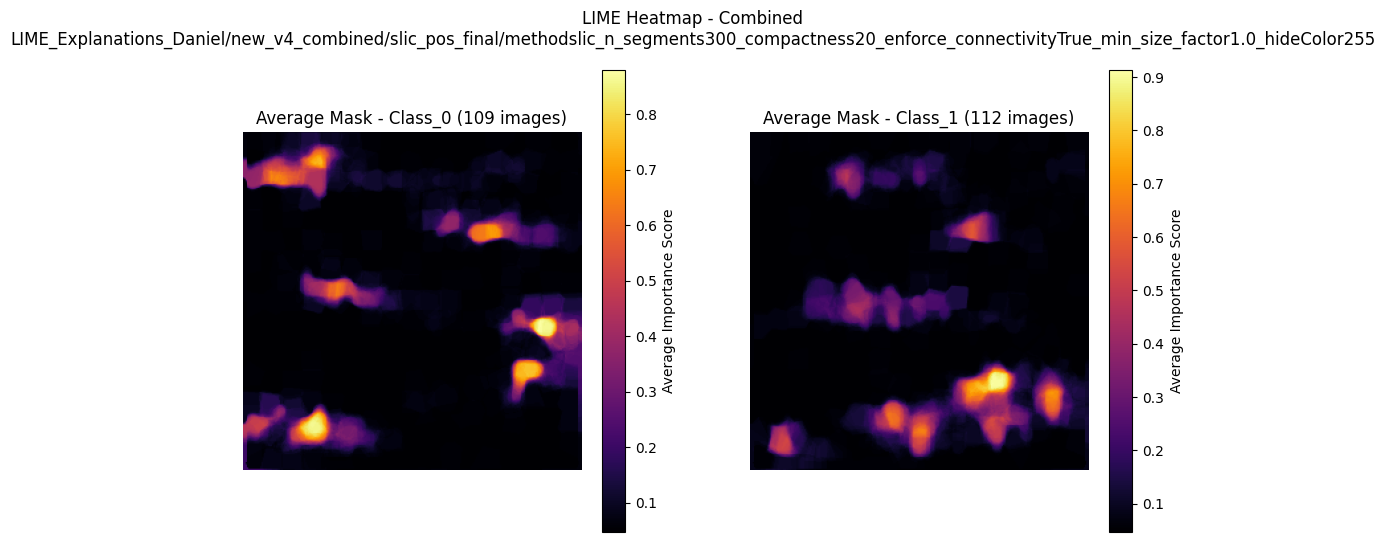

In [16]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
import time

explainer = lime_image.LimeImageExplainer()

# Define different LIME segmentation settings
lime_settings = [
    {"method": "slic", "n_segments": 100, "compactness": 10, "enforce_connectivity": True},
    {"method": "slic", "n_segments": 200, "compactness": 10, "enforce_connectivity": True},
    {"method": "slic", "n_segments": 300, "compactness": 10, "enforce_connectivity": True},

    {"method": "slic", "n_segments": 100, "compactness": 20, "enforce_connectivity": False, "min_size_factor": 1.0},
    {"method": "slic", "n_segments": 200, "compactness": 20, "enforce_connectivity": False, "min_size_factor": 1.0},
    {"method": "slic", "n_segments": 300, "compactness": 20, "enforce_connectivity": False, "min_size_factor": 1.0},

    {"method": "slic", "n_segments": 100, "compactness": 20, "enforce_connectivity": True, "min_size_factor": 1.0},
    {"method": "slic", "n_segments": 200, "compactness": 20, "enforce_connectivity": True, "min_size_factor": 1.0},
    {"method": "slic", "n_segments": 300, "compactness": 20, "enforce_connectivity": True, "min_size_factor": 1.0},
]

# Define different hide_color settings
hide_colors = [255]  # Example: black, gray, white

# Loop over LIME settings and hide_color values
for setting in lime_settings:
    for hide_color in hide_colors:
        # Create a segmentation algorithm with the current setting
        segmenter = SegmentationAlgorithm(setting["method"], **{k: v for k, v in setting.items() if k != "method"})
        
        # Create an output directory for the current setting and hide_color
        setting_name = "_".join(f"{k}{v}" for k, v in setting.items())
        output_dir = f"LIME_Explanations_Daniel/new_v4_combined/slic_pos_final/{setting_name}_hideColor{hide_color}"
        os.makedirs(output_dir, exist_ok=True)
        
        for i, image in enumerate(images):
            start_time = time.time()
            sample_image = (image * 255).astype("uint8")
            if sample_image.shape[-1] == 1:
                sample_image = np.repeat(sample_image, 3, axis=-1)

            with SuppressOutput():
                explanation = explainer.explain_instance(
                    sample_image.astype("double"),
                    predict_fn,
                    segmentation_fn=segmenter,
                    top_labels=1,
                    hide_color=hide_color,
                    num_samples=1000,
                )

            predicted_class = np.argmax(model.predict(image.reshape(1, 256, 256, 1)))
            temp, mask = explanation.get_image_and_mask(predicted_class, positive_only=True, num_features=10, hide_rest=False)

            class_folder = os.path.join(output_dir, f"Class_{predicted_class}")
            os.makedirs(class_folder, exist_ok=True)

            # Save original
            plt.imsave(os.path.join(class_folder, f"Original_{i}_{names[i]}.png"), sample_image[:, :, 0], cmap="gray")
            # Save explanation
            plt.imsave(
                os.path.join(class_folder, f"LIME_Explanation_{i}.png"), mark_boundaries(temp / 255.0, mask, color=(1, 1, 0))
            )
            # Save mask
            plt.imsave(os.path.join(class_folder, f"Mask_{i}.png"), mask, cmap="plasma")

            elapsed = time.time() - start_time
            print(f"Iteration {i} with setting {setting_name} and hide_color {hide_color} took {elapsed:.3f} seconds")

        lime_class_heatmaps(output_dir)